In [70]:
import pandas as pd
import numpy as np
import seaborn as sns

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")


# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score


In [9]:
train = pd.read_csv('/home/saule/ds_bootcamp/Light_GBM/Data/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [14]:
test = pd.read_csv('/home/saule/ds_bootcamp/Light_GBM/Data/test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [35]:
train.groupby('BsmtQual')['SalePrice'].mean()

BsmtQual
Ex    327041.041322
Fa    115692.028571
Gd    202688.478964
TA    140759.818182
Name: SalePrice, dtype: float64

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

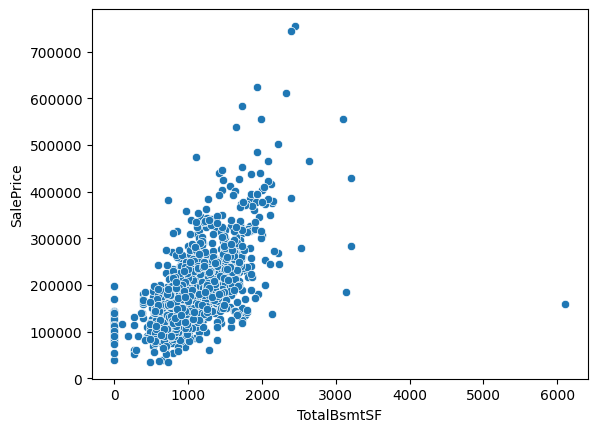

In [28]:
sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice')

In [43]:
train['TotalBsmtSF'].describe()

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

In [41]:
filtered_train = train[train['TotalBsmtSF'] <= 2500]
filtered_train['TotalBsmtSF'].describe()                   # удалить выбросы по площади подвала

count    1453.000000
mean     1046.071576
std       400.387268
min         0.000000
25%       795.000000
50%       990.000000
75%      1288.000000
max      2444.000000
Name: TotalBsmtSF, dtype: float64

In [202]:
train_copy = train.copy()

In [16]:
# Применение логарифмической функции ко всем значениям столбца SalePrice
train['SalePrice2'] = np.log(train['SalePrice'])

In [18]:
train['SalePrice2']

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice2, Length: 1460, dtype: float64

In [19]:
train['SalePrice']

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [21]:
X, y = train.drop('SalePrice', axis=1), train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=None, random_state=42)

In [121]:
# Функция для замены значений "NA" на 0
def replace_na_with_zero(column):
     return column.replace({'NA': 'No', 'nan': 'No', 'None': 'No', np.nan: 'No'})

In [135]:
drop_features = ['Id'] # Эти столбцы считаем не нужными и выкидываем
na_to_zero_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'] 


my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', drop_features),
        ('replace_na', FunctionTransformer(replace_na_with_zero), na_to_zero_columns),
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), ['Electrical'])
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)    

In [203]:
filled_data = my_imputer.fit_transform(train)
train_copy = my_imputer.fit_transform(train_copy)

In [137]:
filled_data['BsmtQual'].isna().sum()

0

In [206]:
filled_data.groupby('Neighborhood')['SalePrice'].mean()

Neighborhood
Blmngtn    194870.882353
Blueste    137500.000000
BrDale     104493.750000
BrkSide    124834.051724
ClearCr    212565.428571
CollgCr    197965.773333
Crawfor    210624.725490
Edwards    128219.700000
Gilbert    192854.506329
IDOTRR     100123.783784
MeadowV     98576.470588
Mitchel    156270.122449
NAmes      145847.080000
NPkVill    142694.444444
NWAmes     189050.068493
NoRidge    335295.317073
NridgHt    316270.623377
OldTown    128225.300885
SWISU      142591.360000
Sawyer     136793.135135
SawyerW    186555.796610
Somerst    225379.837209
StoneBr    310499.000000
Timber     242247.447368
Veenker    238772.727273
Name: SalePrice, dtype: float64

In [139]:
category_mapping = {
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'BsmtExposure': {'Gd': 3, 'Av': 2, 'Mn': 1, 'No': 0},
   # 'BsmtFinType1': {}
}

In [199]:
custom_encoding_columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical']

category_mapping = {
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'BsmtExposure': {'Gd': 5, 'Av': 4, 'Mn': 3, 'No': 2, 'NA': 1},
    'ExterQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'ExterCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
    'BsmtFinType1': {'GLQ': 3, 'ALQ': 2, 'BLQ': 1, 'Rec': 1, 'LwQ': 1, 'Unf': 2, 'No': 0},
    'BsmtFinType2': {'GLQ': 3, 'ALQ': 2, 'BLQ': 1, 'Rec': 1, 'LwQ': 1, 'Unf': 2, 'No': 0},
    'Heating': {'Floor': 0, 'Grav': 0, 'Wall': 1, 'OthW': 2, 'GasW': 3, 'GasA':4},
    'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'Electrical': {'Mix': 0, 'FuseP': 1, 'FuseF': 2, 'FuseA': 3, 'SBrkr': 4}
}

def custom_encode(df):
    for column in df.columns:
        if column in category_mapping:
            df[column] = df[column].map(category_mapping[column])
    return df

In [200]:
ordinal_encoding_columns = ['Foundation']
standard_scaler_columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']
one_hot_encoding_columns = ['CentralAir']

scaler_and_encoder = ColumnTransformer(
    [
        ('custom_encoding', FunctionTransformer(custom_encode), custom_encoding_columns),
        ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling_num_columns', StandardScaler(), standard_scaler_columns)    
   
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

In [204]:
#filled_data = scaler_and_encoder.fit_transform(filled_data)
train_copy = scaler_and_encoder.fit_transform(train_copy)

In [205]:
train_copy

,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,Electrical,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice2
0,3,2,4.0,3.0,2,3,2,4,4,4,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247694
1,2,2,4.0,3.0,5,2,2,4,4,4,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109011
2,3,2,4.0,3.0,3,3,2,4,4,4,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317167
3,2,2,3.0,4.0,2,2,2,4,3,4,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849398
4,3,2,4.0,3.0,4,3,2,4,4,4,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2,2,4.0,3.0,2,2,2,4,4,4,...,NaN,NaN,NaN,0,8,2007,WD,Normal,175000,12.072541
1456,2,2,4.0,3.0,2,2,1,4,2,4,...,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000,12.254863
1457,4,3,3.0,4.0,2,3,2,4,4,4,...,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500,12.493130
1458,2,2,3.0,3.0,3,3,1,4,3,3,...,NaN,NaN,NaN,0,4,2010,WD,Normal,142125,11.864462


In [195]:
ordinal_encoding_columns = ['Foundation']
standard_scaler_columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical']
one_hot_encoding_columns = ['CentralAir']

scaler_and_encoder = ColumnTransformer(
    [
        ('custom_encoding', FunctionTransformer(custom_encode), custom_encoding_columns),
        ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling_num_columns', StandardScaler(), standard_scaler_columns)    
   
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

In [198]:
filled_data = scaler_and_encoder.fit_transform(filled_data)

ValueError: A given column is not a column of the dataframe

In [149]:
train.groupby('BsmtExposure')['SalePrice'].mean()

BsmtExposure
Av    206643.420814
Gd    257689.805970
Mn    192789.657895
No    165652.295908
Name: SalePrice, dtype: float64

In [150]:
filled_data.groupby('BsmtExposure')['SalePrice'].mean()

BsmtExposure
Av    206643.420814
Gd    257689.805970
Mn    192789.657895
No    163439.248234
Name: SalePrice, dtype: float64

In [85]:
filled_data['BsmtQual'].value_counts()

BsmtQual
3.0    649
2.0    618
0.0    121
1.0     35
Name: count, dtype: int64